In [2]:
import numpy as np
import pandas as pd
import category_encoders as ce

In [3]:
data = pd.read_csv('./adult_with_pii.csv')
encoder = ce.OrdinalEncoder(cols=['Target'], return_df=True, mapping=[{'col':'Target',
                                                                       'mapping':{'<=50K':0, '>50K':1}}])
data = encoder.fit_transform(data)
data.dropna(axis=0, how='any', inplace=True)

In [4]:
data = data[['Workclass', 'Education', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country', 'Target']]
key = data[['Workclass', 'Education', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']]
income= data[['Target']]

In [5]:
# Check for duplicates based on categorical columns
data[data.duplicated(keep=False)]

,Workclass,Education,Marital Status,Occupation,Relationship,Race,Sex,Country,Target
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,0
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,0
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,0
5,Private,Masters,Married-civ-spouse,Exec-managerial,Wife,White,Female,United-States,0
7,Self-emp-not-inc,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,1
...,...,...,...,...,...,...,...,...,...
32556,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,Female,United-States,0
32557,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States,1
32558,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,Female,United-States,0
32559,Private,HS-grad,Never-married,Adm-clerical,Own-child,White,Male,United-States,0


Step one: Calculating the risk ceiling. 

In [58]:
# Create an empty list to store the residuals
residuals = []

for index, row in data.iterrows():
    # Filter data to find all matching rows
    match = data[(data['Workclass'] == row['Workclass']) &
                (data['Education'] == row['Education']) &
                (data['Marital Status'] == row['Marital Status']) &
                (data['Occupation'] == row['Occupation']) &
                (data['Relationship'] == row['Relationship']) &
                (data['Race'] == row['Race']) &
                (data['Sex'] == row['Sex']) &
                (data['Country'] == row['Country'])]

    # Calculate the mean salary of the matching rows
    mean_salary = match['Target'].mean()

    # Calculate the residual
    residual = abs(row['Target'] - mean_salary)
    residuals.append(residual)

# Calculating the risk ceiling
RC = sum(residuals) / len(residuals)

In [19]:
RC

0.18552419666058004

Step two: Calculating the risk floor.

In [131]:
residuals = []

# Calculate the overall mean
overal_mean = data['Target'].mean()

for index, row in data.iterrows():
    residual = abs(row['Target'] - overal_mean)
    residuals.append(residual)

RF = sum(residuals) / len(residuals)

In [18]:
RF

0.37392016317027593

Step three: Calculating the risk of the treated data.

In [16]:
# Scoring function to calculate the score for each unique value in a column.
# Returns 1 if the value is equal to the original value, otherwise returns 0.
def scoring_function(value, original_value):
    return 1 if value == original_value else 0

# Exponential mechanism function that takes data, original_value, privacy parameter epsilon, and sensitivity.
# It calculates the scores for each value in the data using the scoring function, and then calculates the probabilities.
# Finally, it returns a treated value based on the probabilities.
def exponential_mechanism(data, original_value, epsilon, sensitivity):
    scores = np.array([scoring_function(value, original_value) for value in data])
    probabilities = np.exp(epsilon * scores / (2 * sensitivity))
    probabilities /= probabilities.sum()
    return np.random.choice(data, p=probabilities)

# Main function to generate treated data using the exponential mechanism.
# This function iterates through each column and row in the DataFrame,
# applies the exponential mechanism, and updates the treated_data DataFrame with the treated values.
def generate_treated_data(df, epsilon):
    treated_data = df.copy()
    df = df.reset_index(drop=True)  # Reset the index of the original DataFrame
    treated_data = treated_data.reset_index(drop=True)  # Reset the index of the treated DataFrame

    # Iterate through each column in the DataFrame
    for col in df.columns.astype(str):
        unique_values = df[col].unique()  # Get unique values in the column
        sensitivity = len(unique_values) - 1  # Calculate the sensitivity for the column

        # Iterate through each row in the DataFrame
        for i in range(len(df)):
            original_value = df.at[i, col]  # Get the original value in the cell
            # Update the treated_data DataFrame with the treated value using the exponential mechanism
            treated_data.at[i, col] = exponential_mechanism(unique_values, original_value, epsilon, sensitivity)

    return treated_data

In [17]:
def treated_data_risk(data, treated_data):
    # Assume treated_df is the treated dataset and orig_df is the original dataset

    # Calculate the overall mean income of the original dataset
    overall_mean_income = data['Target'].mean()

    # Create a dictionary to store the predicted income values for each record in the treated dataset
    predicted_income = {}

    # Match each record in the treated dataset with the original dataset using all categorical variables
    for i, row in treated_data.iterrows():
        match_rows = data[(data['Workclass'] == row['Workclass']) & 
                        (data['Education'] == row['Education']) & 
                        (data['Marital Status'] == row['Marital Status']) &
                        (data['Occupation'] == row['Occupation']) &
                        (data['Relationship'] == row['Relationship']) &
                        (data['Race'] == row['Race']) &
                        (data['Sex'] == row['Sex']) &
                        (data['Country'] == row['Country'])]
        
        # If there are no matches, impute the overall mean as the predicted value
        if len(match_rows) == 0:
            predicted_income[i] = overall_mean_income
        else:
            # Calculate the mean income of the matching rows
            predicted_income[i] = match_rows['Target'].mean()

    residuals = []
    for i, row in treated_data.iterrows():
        residual = abs(predicted_income[i] - row['Target'])
        residuals.append(residual)

    RT = sum(residuals) / len(residuals)
    return RT

In [32]:
def ROC_utility(data, treated_data):
    var_rocs =[]

    for column in ['Workclass', 'Education', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']:
        # calculate frequency table
        orig_counts = data[column].value_counts()
        synth_counts = treated_data[column].value_counts()
        
        roc_df = pd.DataFrame({'yorig': orig_counts, 'ysynth': synth_counts}).fillna(0)

        # calculate ROC for each category
        roc_df['ROC'] = np.minimum(roc_df['yorig'], roc_df['ysynth']) / np.maximum(roc_df['yorig'], roc_df['ysynth'])
        
        # calculate the average ROC for the variable
        var_roc = roc_df['ROC'].mean()
        var_rocs.append(var_roc)
        #print(f"{column}: {var_roc}")
        # print(roc_df)

    return sum(var_rocs)/len(var_rocs)

In [33]:
epsilons = [0.01, 0.1, 1, 5, 10, 15,20,25]
RTs = []
thetas = []

ROCs = []

for epsilon in epsilons:
    treated_data = generate_treated_data(data, epsilon)
    RT = treated_data_risk(data, treated_data)
    RTs.append(RT)

    # theta = (RT - RF) / (RC - RF)
    theta = (RT - RC) / (RF - RC)
    thetas.append(theta)

    ROC = ROC_utility(data, treated_data)
    ROCs.append(ROC)

Workclass: 0.28999439599023885
Education: 0.3368451836486779
Marital Status: 0.3202313080634021
Occupation: 0.4989601836891227
Relationship: 0.5052934768837181
Race: 0.18732254803795453
Sex: 0.6848407083826963
Country: 0.08912627137795742
Workclass: 0.2882639789216262
Education: 0.34259204834669343
Marital Status: 0.3189242824191335
Occupation: 0.5001139431968299
Relationship: 0.5074038581652897
Race: 0.18520007250191942
Sex: 0.7074558121996435
Country: 0.08908478193285874
Workclass: 0.2891611116718066
Education: 0.338397307982909
Marital Status: 0.3235389776642958
Occupation: 0.5011536736383613
Relationship: 0.5099117457614423
Race: 0.1924021137479445
Sex: 0.7553914558147887
Country: 0.08894811326750843
Workclass: 0.3084352330751457
Education: 0.34172485174775136
Marital Status: 0.33385793183571444
Occupation: 0.504211989405501
Relationship: 0.5363222033696273
Race: 0.2237733710497393
Sex: 0.9459938345756491
Country: 0.08960350978530598
Workclass: 0.33503547363710007
Education: 0.3458

In [34]:
print("RT:", RTs)
print("theta:", thetas)
print("Utility:", ROCs)

[0.49979167817262415, 0.49428099205211395, 0.47103299695931883, 0.392371633422929, 0.3754144503595453, 0.3740851886666802, 0.3734608932523039, 0.37344886665888527]
[1.66812213304933, 1.6388715804891905, 1.5154719370493792, 1.0979398370065607, 1.0079316304746495, 1.0008759502629574, 0.9975622093907813, 0.997498372602545]
[0.36407675950922097, 0.3673798472104993, 0.3748630624436321, 0.41049036560555424, 0.435048889938227, 0.4565635137989274, 0.48553181476817797, 0.5166189182217306]


epsilons = [0.01, 0.1, 1, 5, 10, 15,20,25]
thetas = [1.66812213304933, 1.6388715804891905, 1.5154719370493792, 1.0979398370065607, 1.0079316304746495, 1.0008759502629574, 0.9975622093907813, 0.997498372602545]
ROCs = [0.36407675950922097, 0.3673798472104993, 0.3748630624436321, 0.41049036560555424, 0.435048889938227, 0.4565635137989274, 0.48553181476817797, 0.5166189182217306]

In [9]:
# epsilons = [0.01, 0.1, 1, 5, 10, 15,20,25]
# thetas = [1.66812213304933, 1.6388715804891905, 1.5154719370493792, 1.0979398370065607, 1.0079316304746495, 1.0008759502629574, 0.9975622093907813, 0.997498372602545]
# ROCs = [0.36407675950922097, 0.3673798472104993, 0.3748630624436321, 0.41049036560555424, 0.435048889938227, 0.4565635137989274, 0.48553181476817797, 0.5166189182217306]

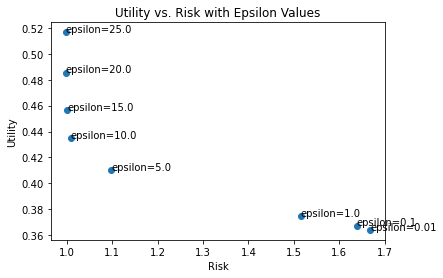

In [11]:
import matplotlib.pyplot as plt

# Plot scatter plot
plt.scatter(thetas, ROCs)


# Add epsilon values on each point
for i, txt in enumerate(epsilons):
    plt.annotate("epsilon=" + str(txt), (thetas[i], ROCs[i]))


# Set plot title and axis labels
plt.title("Utility vs. Risk with Epsilon Values")
plt.xlabel("Risk")
plt.ylabel("Utility")

# Display plot
plt.show()


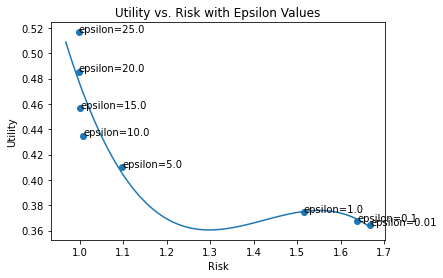

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some sample data
thetas = np.array(thetas)
ROCs = np.array(ROCs)
epsilons = np.array(epsilons)

# Fit a polynomial curve to the data
curve_fit = np.polyfit(thetas, ROCs, deg=3)
curve = np.poly1d(curve_fit)

# Create a smooth line using the curve function
x = np.linspace(thetas.min()-0.03, thetas.max(), 100)
y = curve(x)

# Plot the smooth line and scatter plot
plt.plot(x, y, '-')
plt.scatter(thetas, ROCs)

# Add epsilon values on each point
for i, txt in enumerate(epsilons):
    plt.annotate("epsilon=" + str(txt), (thetas[i], ROCs[i]))

# Set plot title and axis labels
plt.title("Utility vs. Risk with Epsilon Values")
plt.xlabel("Risk")
plt.ylabel("Utility")

# Display plot
plt.show()
